### Predictive Models

This notebook outlines the steps involved in building models incorporating **building, economic and socio-demographic factors**, including RF, SVR, ANN and OLS. The notebook then shows how to identify the significance of the characteristics.

In [1]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
df = pd.read_csv('data/transformed_df.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8699 entries, 0 to 8698
Data columns (total 50 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   LandUse                                                          8699 non-null   int64  
 1   LotArea                                                          8699 non-null   float64
 2   BldgArea                                                         8699 non-null   float64
 3   NumBldgs                                                         8699 non-null   int64  
 4   NumFloors                                                        8699 non-null   float64
 5   UnitsRes                                                         8699 non-null   int64  
 6   LotFront                                                         8699 non-null   float64
 7   LotDepth                                  

In [4]:
X = df[
    ['LandUse','LotArea', 'BldgArea', 'NumBldgs','NumFloors','ProxCode', 'UnitsRes', 'LotFront', 'LotDepth', 'BldgFront',
     'BldgDepth','LotType', 'AssessLand','BuiltFAR', 'BoroCode',
     'LargestPropertyUseTypeGrossFloorArea','Building_Age',
    'Mean_household_income_(dollars)','Civilian_noninstitutionalized_population_with_private_insurance', 
     'Population_with_determined_poverty_status','Population_with_65_years_and_over', 'Population',
     'Total_households', 'School_Employees', 'Population_with_bachelor_degree_or_higher', 'Married_males',
     'Married_females', 'Average_household_size', 'Vacant_housing_units', 'Median_Gross_Rent_(dollars)',
     'Housing_units_with_3_or_more_vehicles_available']
].values 
y = df['Weather_Normalized_Site_Energy_Use_(kBtu)'].values

In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define models
models = {
    'RF': RandomForestRegressor(),
    'SVR': SVR(),
    'ANN': MLPRegressor(),
    'OLS': LinearRegression()
}

# Store results
results = {model: {'R2': [], 'MAE': [], 'CVRMSE': [], 'RMSE': [], 'MAPE': []} for model in models.keys()}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        predictions = model.predict(X_val_fold)

        r2 = r2_score(y_val_fold, predictions)
        mae = mean_absolute_error(y_val_fold, predictions)
        rmse = mean_squared_error(y_val_fold, predictions, squared=False)
        cvrmse = rmse / np.mean(y_val_fold) * 100
        mape = np.mean(np.abs((y_val_fold - predictions) / y_val_fold)) * 100

        results[name]['R2'].append(r2)
        results[name]['MAE'].append(mae)
        results[name]['CVRMSE'].append(cvrmse)
        results[name]['RMSE'].append(rmse)
        results[name]['MAPE'].append(mape)

In [6]:
# Print the average performance metrics for each model
for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    for metric_name, metric_values in metrics.items():
        mean_value = np.mean(metric_values)
        print(f"  {metric_name}: {mean_value:.4f}")
    print()

Results for RF:
  R2: 0.7099
  MAE: 0.3218
  CVRMSE: 3.1997
  RMSE: 0.4984
  MAPE: 2.1175

Results for SVR:
  R2: 0.0709
  MAE: 0.6458
  CVRMSE: 5.7234
  RMSE: 0.8916
  MAPE: 4.1468

Results for ANN:
  R2: -5424.2620
  MAE: 53.3759
  CVRMSE: 433.7622
  RMSE: 67.5614
  MAPE: 343.9120

Results for OLS:
  R2: 0.6886
  MAE: 0.3393
  CVRMSE: 3.3151
  RMSE: 0.5164
  MAPE: 2.2355



#### Feature Importance Identification

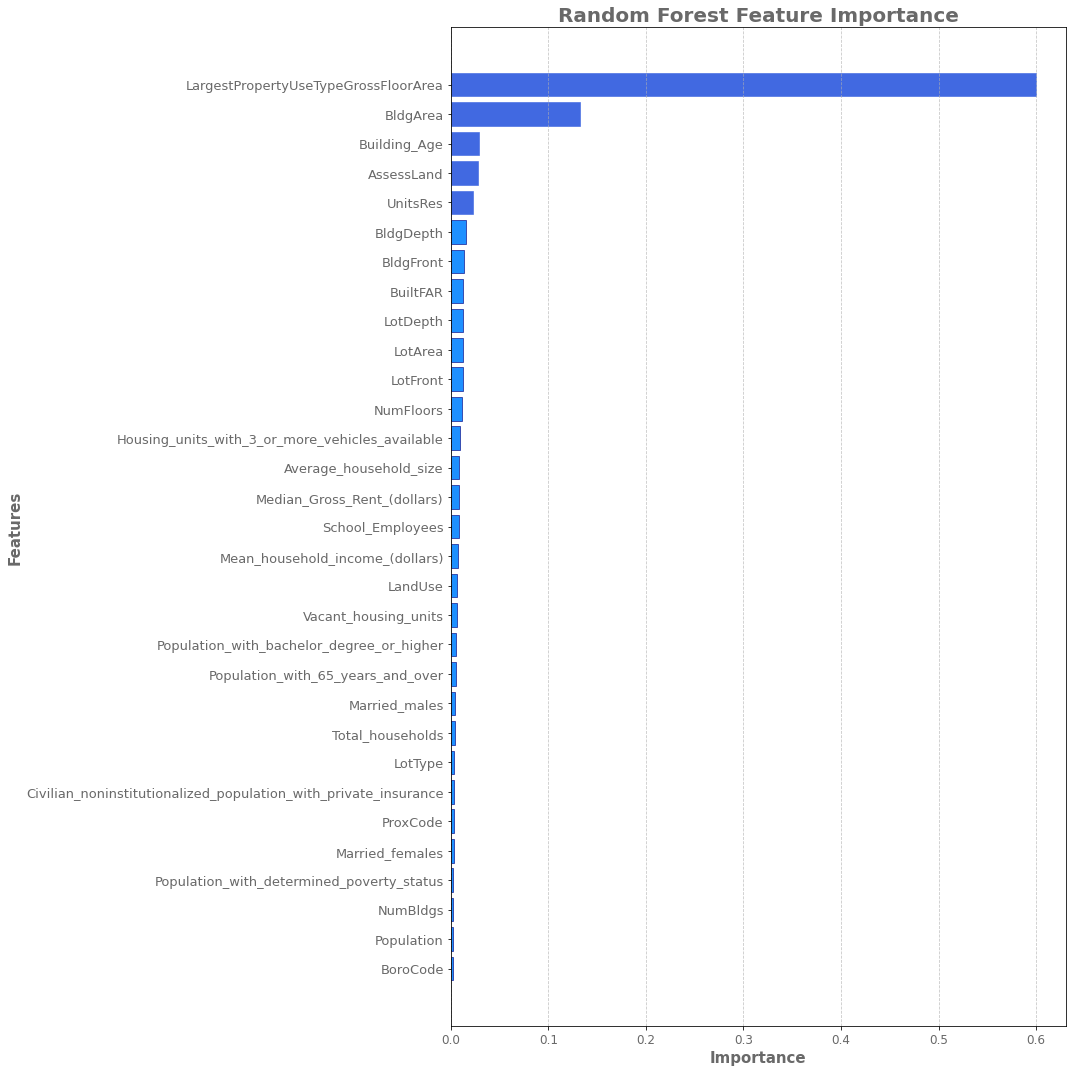

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Feature names
feature_names = [
    'LandUse', 'LotArea', 'BldgArea', 'NumBldgs', 'NumFloors', 'ProxCode', 'UnitsRes', 'LotFront', 'LotDepth', 'BldgFront',
    'BldgDepth', 'LotType', 'AssessLand', 'BuiltFAR', 'BoroCode', 'LargestPropertyUseTypeGrossFloorArea', 'Building_Age',
    'Mean_household_income_(dollars)', 'Civilian_noninstitutionalized_population_with_private_insurance',
    'Population_with_determined_poverty_status', 'Population_with_65_years_and_over', 'Population', 'Total_households',
    'School_Employees', 'Population_with_bachelor_degree_or_higher', 'Married_males', 'Married_females', 'Average_household_size',
    'Vacant_housing_units', 'Median_Gross_Rent_(dollars)', 'Housing_units_with_3_or_more_vehicles_available'
]

# Extract the feature importances and sort them in descending order for plotting
importances = models['RF'].feature_importances_
sorted_indices = np.argsort(importances)[::-1]

# Creating the enhanced bar chart
plt.figure(figsize=(15, 15))
bars = plt.barh(np.array(feature_names)[sorted_indices], 
                importances[sorted_indices], 
                color='dodgerblue', 
                edgecolor='navy', 
                linewidth=0.6)

# Highlighting the top 5 features with a different color
top_features = 5
for i in range(top_features):
    bars[i].set_color('royalblue')

plt.xlabel('Importance', fontsize=15, fontweight='bold', color='dimgray')
plt.ylabel('Features', fontsize=15, fontweight='bold', color='dimgray')
plt.title('Random Forest Feature Importance', fontsize=20, fontweight='bold', color='dimgray')
plt.xticks(fontsize=12, color='dimgray')
plt.yticks(fontsize=13, color='dimgray')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()


In [8]:
# Extract the top 20 feature importances and their names
top_n = 20
top_importances = importances[sorted_indices][:top_n]
top_features = np.array(feature_names)[sorted_indices][:top_n]

# Displaying the top 20 features and their importance values
for feature, importance in zip(top_features, top_importances):
    print(f"{feature}: {importance:.4f}")

LargestPropertyUseTypeGrossFloorArea: 0.6002
BldgArea: 0.1325
Building_Age: 0.0292
AssessLand: 0.0281
UnitsRes: 0.0229
BldgDepth: 0.0158
BldgFront: 0.0132
BuiltFAR: 0.0129
LotDepth: 0.0129
LotArea: 0.0128
LotFront: 0.0125
NumFloors: 0.0113
Housing_units_with_3_or_more_vehicles_available: 0.0092
Average_household_size: 0.0084
Median_Gross_Rent_(dollars): 0.0082
School_Employees: 0.0081
Mean_household_income_(dollars): 0.0076
LandUse: 0.0063
Vacant_housing_units: 0.0061
Population_with_bachelor_degree_or_higher: 0.0054


In [9]:
# Fit the RF model on the entire training set
rf_model = models['RF']
rf_model.fit(X_train, y_train)

# Predict the values for the entire dataset
predicted_values = rf_model.predict(X)

# Add the predicted values to the dataframe
df['predicted_value'] = predicted_values

print(df[['Weather_Normalized_Site_Energy_Use_(kBtu)', 'predicted_value']].head())

   Weather_Normalized_Site_Energy_Use_(kBtu)  predicted_value
0                                  16.168388        16.492204
1                                  14.889625        14.958261
2                                  15.818122        15.813206
3                                  17.879746        18.075474
4                                  14.561637        14.636966


In [10]:
# Calculate the residuals
df['Residuals'] = df['Weather_Normalized_Site_Energy_Use_(kBtu)'] - df['predicted_value']

# Display the relevant columns
print(df[['Weather_Normalized_Site_Energy_Use_(kBtu)', 'predicted_value', 'Residuals']].head())


   Weather_Normalized_Site_Energy_Use_(kBtu)  predicted_value  Residuals
0                                  16.168388        16.492204  -0.323816
1                                  14.889625        14.958261  -0.068636
2                                  15.818122        15.813206   0.004916
3                                  17.879746        18.075474  -0.195728
4                                  14.561637        14.636966  -0.075328


In [11]:
df['original_Weather_Normalized_Site_Energy_Use_(kBtu)'] = np.expm1(df['Weather_Normalized_Site_Energy_Use_(kBtu)'])
df['original_predicted_value'] = np.expm1(df['predicted_value'])

In [12]:
df.head()

,LandUse,LotArea,BldgArea,NumBldgs,NumFloors,UnitsRes,LotFront,LotDepth,BldgFront,BldgDepth,...,Married_males,Married_females,Average_household_size,Vacant_housing_units,Median_Gross_Rent_(dollars),Housing_units_with_3_or_more_vehicles_available,predicted_value,Residuals,original_Weather_Normalized_Site_Energy_Use_(kBtu),original_predicted_value
0,5,9.469700,12.092125,1,2.639057,0,4.884694,4.602667,0.000000,0.0,...,30271,26227,1.68,4987,2331.0,5.129899,16.492204,-0.323816,10515786.1,1.453695e+07
1,3,8.381832,10.869406,1,2.564949,13,3.832330,4.602667,3.784190,90.0,...,30271,26227,1.68,4987,2331.0,5.129899,14.958261,-0.068636,2927399.8,3.135381e+06
2,4,9.569343,11.244405,1,1.945910,77,4.823663,4.795791,4.820282,120.0,...,30271,26227,1.68,4987,2331.0,5.129899,15.813206,0.004916,7408374.5,7.372045e+06
3,5,10.450539,14.078435,1,3.761200,0,5.290789,5.170484,5.283204,173.0,...,30271,26227,1.68,4987,2331.0,5.129899,18.075474,-0.195728,58220390.1,7.080740e+07
4,3,8.754003,10.395711,1,2.079442,35,4.080415,4.705016,4.077537,97.0,...,30271,26227,1.68,4987,2331.0,5.129899,14.636966,-0.075328,2108815.0,2.273805e+06


In [13]:
# Save dataframe to a CSV file
df.to_csv('data/energy_mapping1.csv', index=False)